# Projeto 2 - CDados

### Autores: Diego Guimarães Nuñez, Felipe Bakowski Nantes de Souza, Gustavo de Lima Mota

### Tema: Conseguimos prever o número de homicídios nos municípios do Estado de SP, que não são capital, em um ano no estado de São Paulo?

### Features: IDH por município, Proporção de crianças (6-14 anos) fora da escola, Proporção de vulnerabilidade socioeconêmica, Proporção de pessoas sem água e esgoto, e Índice de Gini por município.

### Fonte : basedosdados.org

In [468]:
import basedosdados as bd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn import tree
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression 
from sklearn import linear_model

### Baixando as bases de dados utilizadas no projeto:

In [469]:
homicidio = bd.read_table(dataset_id='br_sp_gov_ssp',
table_id='ocorrencias_registradas',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 153876/153876 [00:31<00:00, 4817.77rows/s]


In [470]:
ivs = bd.read_table(dataset_id='br_ipea_avs',
table_id='municipio',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 319681/319681 [06:30<00:00, 819.21rows/s] 


## Refletindo sobre os problemas sociais presentes em São Paulo, um dos mais notáveis é a abundante taxa de criminalidade, especificando ainda mais, a taxa de homicídio. Visado a target (problema o qual é pretendido visualizar), foi-se pensado em possíveis targets quais estão ligadas com o tema tido em vista, que são: Índice de Gini, Indice de desenvolvimento Humano, Proporcao de populacao sem esgoto, Proporcao de crianças que sairam da escola entre 6 a 14 anos e Proporcao de Vulnerabilidade Socioeconomica.
## Tendo em vista a target com suas respectivas features, é pretendido realizar a criação de um modelo com capacidade de previsão para a criminalidade, entendendo intrinsicamente as relações individuais de cada feature com a target. A partir da criação do modelo, é facilitada a visão das 'raízes' do problema, possibilitando possíveis tomadas de decisões pessoais e governamentais para tratar esse severo problema.

### Primeiramente, vamos tratar a base de dados de homicidios e deixá-la mais visualizável

### Além disso, estamos retirando a Capital SP da análise, pois, ela se comporta de maneira muito distinta em relação ao interior, resultando em dados muito aberrantes. Assim, consideramos que ela é um outlier e deve ser retirada para realizarmos uma melhor análise

In [471]:
homicidio['Homicidio_total'] = homicidio.loc[:, ['homicidio_doloso', 'homicidio_culposo_outros']].sum(axis=1) #homicidio total
homicidio_2010 = homicidio.loc[(homicidio['ano'] == 2010)]
homicidio_filtrado = homicidio_2010.loc[:,('ano','id_municipio', 'regiao_ssp', 'Homicidio_total')] #selecionando colunas
homicidio_ano = homicidio_filtrado.groupby(['ano', 'id_municipio', 'regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()

 ### Agora devemos tratar a base IVS, para que, consigamos utilizar as colunas:  Prop_crianca_fora_escola_6_14, IDHM (IDH por municipio), Proporção_vulnerabilidade_socioeconomica (proporção de pessoas com renda per capita inferior a meio salario mínimo e que gastam mais de uma hora até chegar no trabalho), proporção_sem_agua_esgoto, Índice de Gini

In [472]:
#filtrando ivs
ivs_filtrado = ivs.loc[:,('ano','id_municipio','sigla_uf','idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini')]
ivs_t = ivs_filtrado.loc[(ivs['sigla_uf'] == 'SP') & (ivs['ano'] == 2010)]
ivs_novo = ivs_t.dropna()
ivs_novo2 = ivs_novo.drop_duplicates(subset='id_municipio', keep = 'first')

#criando tabela 
tabela_final = pd.merge(ivs_novo2, homicidio_ano[['id_municipio', 'Homicidio_total']], on='id_municipio', how='left')
tabela_definitiva = tabela_final.dropna()
tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260] # identificando São Paulo
tabela_sem_sp = tabela_definitiva.drop(tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260].index) # tirando São Paulo
tabela_sem_sp.describe()

,ano,idhm,renda_per_capita,proporcao_analfabetismo_15_mais,proporcao_sem_renda_18_mais,indice_gini,Homicidio_total
count,639.0,639.000000,639.000000,639.000000,639.000000,639.000000,639.000000
mean,2010.0,0.763746,802.356620,6.071049,3.066182,0.456135,5.244131
std,0.0,0.034519,240.292539,2.441283,2.853549,0.059192,13.881830
min,2010.0,0.655000,348.790000,1.010000,0.000000,0.320000,0.000000
25%,2010.0,0.742000,649.415000,4.280000,1.290000,0.410000,0.000000
50%,2010.0,0.763000,761.590000,5.840000,2.080000,0.450000,1.000000
75%,2010.0,0.785000,904.240000,7.485000,3.835000,0.490000,4.000000
max,2010.0,0.891000,2729.860000,17.090000,24.480000,0.740000,168.000000


### Agora deve-se dividir o nosso dataframe em treino e teste

In [473]:
tabela_sem_sp = tabela_sem_sp.sample(frac=1) #mudando a ordem das linhas, a fim de, garantir que os df estejam equilibrados

In [533]:
#nota : id_municipio não entra como feature, mas, coloca-se ele na base para ter uma manipulação mais fácil
X_treino_r, X_teste_r, y_treino_r, y_teste_r = train_test_split(tabela_sem_sp[['id_municipio','idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']], tabela_sem_sp['Homicidio_total'], test_size=0.2, random_state=42)

### Entendendo como a target (homicídio) se comporta em relação aos municípios

### De início, tem-se um crosstab da porcentagem de homicícios, por município, em 2010.Além de, um gráfico de barras do homicídio, no Estado, dos municípios. Tal que, este será utilizado para a validação do modelo no futuro

In [534]:
homicidio_mun = homicidio.groupby(['ano','id_municipio','regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()
homicidio_mun = homicidio_mun.loc[(homicidio_mun['regiao_ssp']!='Capital')] #retirando a capital
homicidio_mun_2010 = homicidio_mun.loc[homicidio_mun.ano == 2010]

In [535]:
pd.crosstab(homicidio_mun_2010.Homicidio_total, homicidio_mun_2010.id_municipio, margins=True).round(4)

id_municipio,3500105,3500204,3500303,3500402,3500501,3500550,3500600,3500709,3500758,3500808,...,3556701,3556800,3556909,3556958,3557006,3557105,3557154,3557204,3557303,All
Homicidio_total,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,1,0,1,0,1,1,...,0,0,1,1,0,0,1,0,1,239
1.0,1,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,124
2.0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,58
3.0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,45
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,9
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


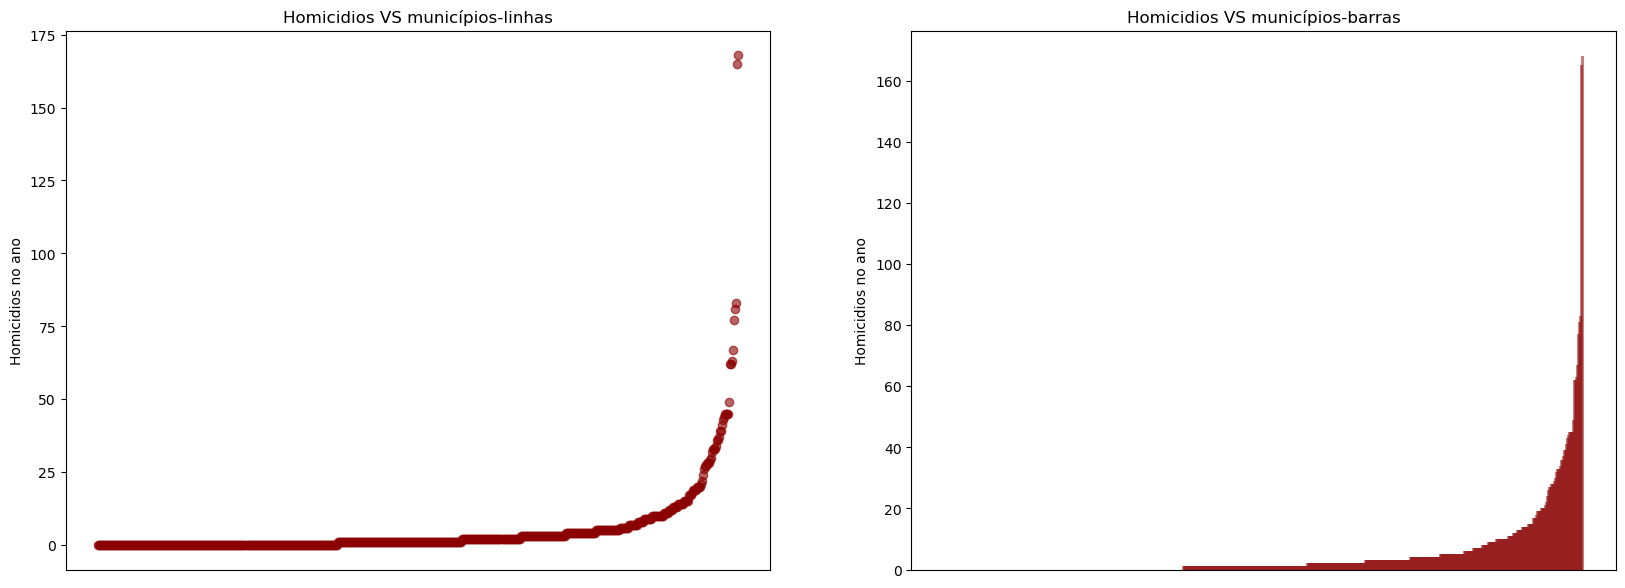

In [536]:
hom_ord = homicidio_mun_2010.sort_values('Homicidio_total')#ordenando os valores para ajudar na visibilidade

plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.scatter(hom_ord.id_municipio, hom_ord.Homicidio_total, color='darkred', alpha=0.6)
plt.xlabel('Municípios')
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS municípios-linhas')

plt.subplot(1,2,2)
plt.bar(hom_ord.id_municipio, hom_ord.Homicidio_total, color='darkred', width=3, alpha=0.5)
plt.xlabel('Municípios')
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS municípios-barras')


plt.show()

 ### Então, deve-se entender as correlações entre as features e variáveis, para que seja possível diagnosticar futuros erros

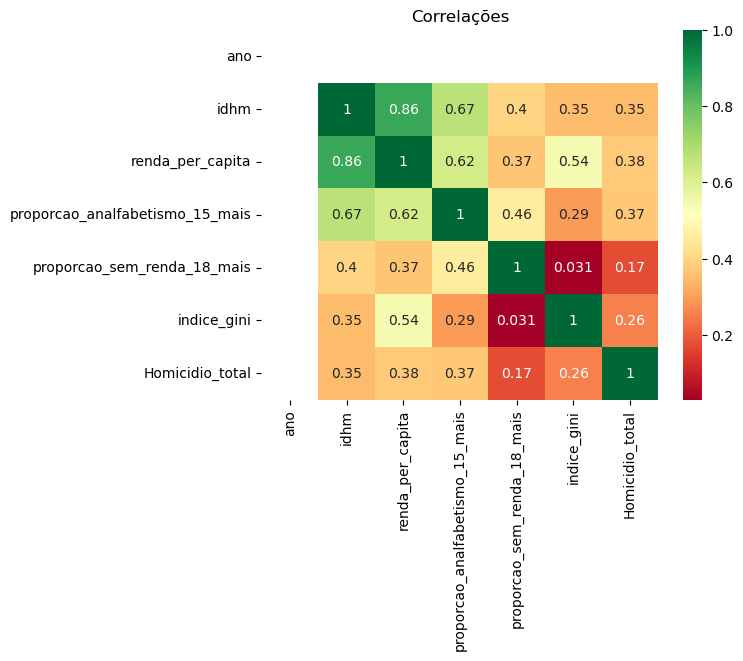

In [537]:
sns.heatmap(abs(tabela_sem_sp.corr()), annot = True, cmap= "RdYlGn") #nota : apenas para valores absolutos
plt.title('Correlações')
plt.show()

### Por fim, plota-se os gráficos de dispersão + .corr

### Nota: Esses gráficos de dispersão são referentes ao ano 2010

Correlação entre homicídios e idhm é moderada e possui valor de 0.3471078490441474
Correlação entre homicídios e renda per capita é moderada e possui valor de 0.37615560758103544
Correlação entre homicídios e prop. de analfabetismo é moderada e possui valor de -0.3716878242202825
Correlação entre homicídios e prop. pessoas sem renda é fraca e possui valor de -0.1733377810194882
Correlação entre homicídios e indice gini é fraca e possui valor de 0.25637691857264316


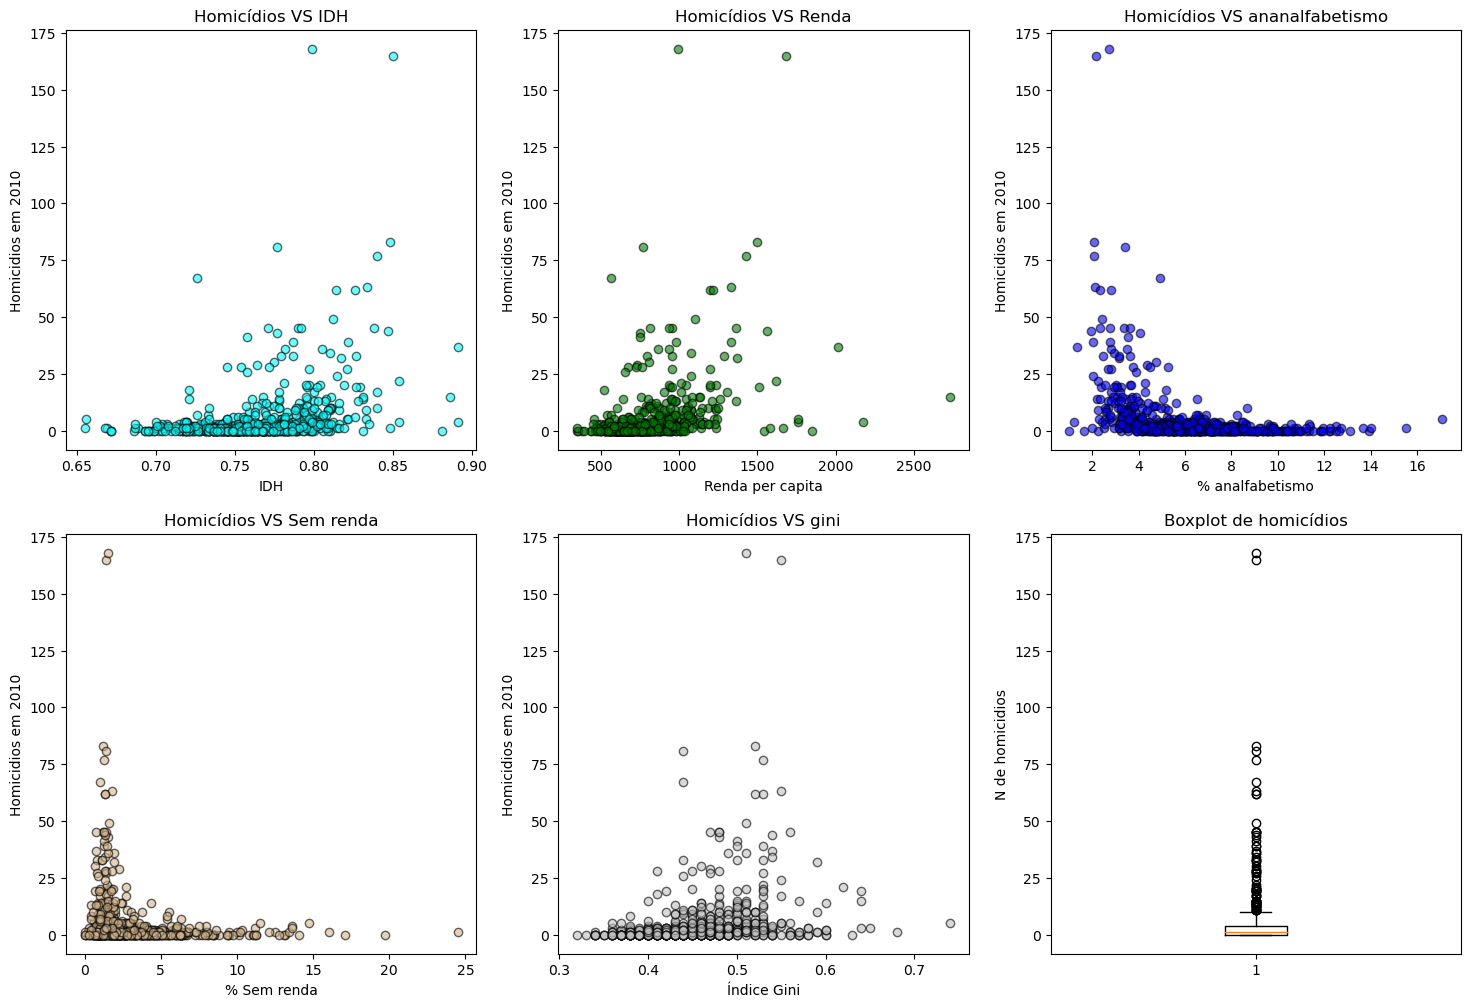

In [538]:
plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.scatter(tabela_sem_sp['idhm'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='cyan', edgecolors="black")
plt.xlabel('IDH')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS IDH')
corr_idhm = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['idhm'])
if abs(corr_idhm) < 0.3:
    print(f'Correlação entre homicídios e idhm é fraca e possui valor de {corr_idhm}')
elif abs(corr_idhm) >0.3 and (corr_idhm) < 0.7:
    print(f'Correlação entre homicídios e idhm é moderada e possui valor de {corr_idhm}')
elif abs(corr_idhm) > 0.7:
    print(f'Correlação entre homicídios e idhm é forte e possui valor de {corr_idhm}')

plt.subplot(2,3,2)
plt.scatter(tabela_sem_sp['renda_per_capita'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='green', edgecolors="black")
plt.xlabel('Renda per capita')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Renda')
corr_renda = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['renda_per_capita'])
if abs(corr_renda) < 0.3:
    print(f'Correlação entre homicídios e renda per capita é fraca e possui valor de {corr_renda}')
elif abs(corr_renda) >0.3 and (corr_renda) < 0.7:
    print(f'Correlação entre homicídios e renda per capita é moderada e possui valor de {corr_renda}')
elif abs(corr_renda) > 0.7:
    print(f'Correlação entre homicídios e renda per capita é forte e possui valor de {corr_renda}')

plt.subplot(2,3,3)
plt.scatter(tabela_sem_sp['proporcao_analfabetismo_15_mais'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='blue', edgecolors="black")
plt.xlabel('% analfabetismo')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS ananalfabetismo')
corr_analfab = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['proporcao_analfabetismo_15_mais'])
if abs(corr_analfab) < 0.3:
    print(f'Correlação entre homicídios e prop. de analfabetismo é fraca e possui valor de {corr_analfab}')
elif abs(corr_analfab) >0.3 and (corr_analfab) < 0.7:
    print(f'Correlação entre homicídios e prop. de analfabetismo é moderada e possui valor de {corr_analfab}')
elif abs(corr_analfab) > 0.7:
    print(f'Correlação entre homicídios e prop. de analfabetismo é forte e possui valor de {corr_analfab}')

plt.subplot(2,3,4)
plt.scatter(tabela_sem_sp['proporcao_sem_renda_18_mais'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='tan', edgecolors="black")
plt.xlabel('% Sem renda')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Sem renda')
corr_sem_renda = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['proporcao_sem_renda_18_mais'])
if abs(corr_sem_renda) < 0.3:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é fraca e possui valor de {corr_sem_renda}')
elif abs(corr_sem_renda) >0.3 and (corr_sem_renda) < 0.7:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é moderada e possui valor de {corr_sem_renda}')
elif abs(corr_sem_renda) > 0.7:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é forte e possui valor de {corr_sem_renda}')

plt.subplot(2,3,5)
plt.scatter(tabela_sem_sp['indice_gini'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='silver', edgecolors="black")
plt.xlabel('Índice Gini')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS gini')
corr_gini = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['indice_gini'])
if abs(corr_gini) < 0.3:
    print(f'Correlação entre homicídios e indice gini é fraca e possui valor de {corr_gini}')
elif abs(corr_gini) >0.3 and (corr_gini) < 0.7:
    print(f'Correlação entre homicídios e indice gini é moderada e possui valor de {corr_gini}')
elif abs(corr_gini) > 0.7:
    print(f'Correlação entre homicídios e indice gini é forte e possui valor de {corr_gini}')

plt.subplot(2,3,6)
plt.boxplot(tabela_sem_sp['Homicidio_total'])
plt.title('Boxplot de homicídios')
plt.ylabel('N de homicidios')

plt.show()

### Possíveis fontes de erro:

### Ao analisarmos a função .agg observamos que ela fazia com que existisse alguns pontos aberrantes, por exemplo, em sp tinhamos 1260 homicídios. Logo, tiramos esse ponto aberrante e trabalharemos com essa possibilidade de erro para as próximas análises

### Agora iremos criar um modelo de regressão linear com múltiplas variáveis, utilizando o df treino

In [539]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [540]:
X = X_treino_r[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']]

Y = y_treino_r

In [541]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     22.96
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           8.62e-21
Time:                        02:32:44   Log-Likelihood:                -2028.3
No. Observations:                 511   AIC:                             4069.
Df Residuals:                     505   BIC:                             4094.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -7.4252     27.084     -0.274      0.784     -60.636      45.786
idhm                                0.3965     36.178      0.011      0.991     -70.681      71.474
renda_per_capita                    0.0140      0.006      2.508      0.012       0.003       0.025
proporcao_analfabetismo_15_mais    -1.1572      0.326     -3.546      0.000      -1.798      -0.516
proporcao_sem_renda_18_mais        -0.0064      0.234     -0.027      0.978      -0.467       0.454
indice_gini                        17.7221     12.603      1.406      0.160      -7.039      42.484
==============================================================================
Omnibus:                      701.670   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115651.323
Skew:                           7.043   Prob(JB):                         0.00
Kurtosis:                      75.342   Cond. No.                     6.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Então, precisamos analisar quais variáveis serão desejáveis para a análise. Para isso iremos utilizar um processo iterativo de rodar o modelo e avaliar se o valor P está acima de 10% (índice de significância), caso esteja, ele deverá ser retirado e rodaremos o modelo denovo até que achemos todas as variáveis relevantes.

In [542]:
X = X_treino_r[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais','indice_gini']]

Y = y_treino_r

In [543]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     28.75
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.50e-21
Time:                        02:32:56   Log-Likelihood:                -2028.3
No. Observations:                 511   AIC:                             4067.
Df Residuals:                     506   BIC:                             4088.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -7.4475     27.045     -0.275      0.783     -60.582      45.687
idhm                                0.4492     36.091      0.012      0.990     -70.458      71.356
renda_per_capita                    0.0140      0.006      2.538      0.011       0.003       0.025
proporcao_analfabetismo_15_mais    -1.1593      0.317     -3.656      0.000      -1.782      -0.536
indice_gini                        17.6297     12.134      1.453      0.147      -6.210      41.470
==============================================================================
Omnibus:                      701.642   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115629.491
Skew:                           7.043   Prob(JB):                         0.00
Kurtosis:                      75.335   Cond. No.                     6.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [544]:
X = X_treino_r[['renda_per_capita','proporcao_analfabetismo_15_mais','indice_gini']]

Y = y_treino_r

In [545]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     38.41
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           2.21e-22
Time:                        02:33:01   Log-Likelihood:                -2028.3
No. Observations:                 511   AIC:                             4065.
Df Residuals:                     507   BIC:                             4082.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -7.1175      5.348     -1.331      0.184     -17.625       3.390
renda_per_capita                    0.0141      0.004      4.015      0.000       0.007       0.021
proporcao_analfabetismo_15_mais    -1.1607      0.297     -3.903      0.000      -1.745      -0.576
indice_gini                        17.5830     11.526      1.525      0.128      -5.063      40.228
==============================================================================
Omnibus:                      701.622   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115618.822
Skew:                           7.043   Prob(JB):                         0.00
Kurtosis:                      75.331   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [546]:
X = X_treino_r[['renda_per_capita','proporcao_analfabetismo_15_mais']]

Y = y_treino_r

In [547]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     56.31
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           8.16e-23
Time:                        02:33:04   Log-Likelihood:                -2029.5
No. Observations:                 511   AIC:                             4065.
Df Residuals:                     508   BIC:                             4078.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.4628      3.860     -0.379      0.705      -9.047       6.121
renda_per_capita                    0.0167      0.003      5.499      0.000       0.011       0.023
proporcao_analfabetismo_15_mais    -1.1252      0.297     -3.790      0.000      -1.708      -0.542
==============================================================================
Omnibus:                      700.403   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114205.376
Skew:                           7.024   Prob(JB):                         0.00
Kurtosis:                      74.878   Cond. No.                     5.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Agora que apenas as features relevantes sobraram, devemos análisar a correlação entre os erros do modelo. Para isso, utilizaremos o valor de Durbin-Watson.

### No caso, esse valor é de 1,995

In [548]:
resultado = 2*(1-1.995)

In [530]:
resultado

-1.9900000000000002

### Como esse resultado está muito próximo de 2, pode-se afirmar que a correlação entre os erros é bem baixa !

### Agora, nós podemos fazer uma análise da nossa regressão linear composta e avaliar se ela responde a nossa pergunta inicial. Para isso, iremos calcular a diferença entre os valores reais e os criados pelo modelo, a fim de, realizar uma análise exploratória neles e compreender seu funcionamento

In [561]:
y = modelo_regress.predict()
X_treino_r['Homicidio_total'] = pd.Series(y_treino_r)
X_teste_r['Homicidio_total'] = pd.Series(y_treino_r)
df_modelo1 = X_treino_r.loc[:, ('id_municipio', 'Homicidio_total', 'proporcao_analfabetismo_15_mais','renda_per_capita')]
df_modelo1['y'] = y
df_modelo1['diferença'] = df_modelo1.Homicidio_total-df_modelo1.y
df_modelo1 = df_modelo1.sort_values('diferença')

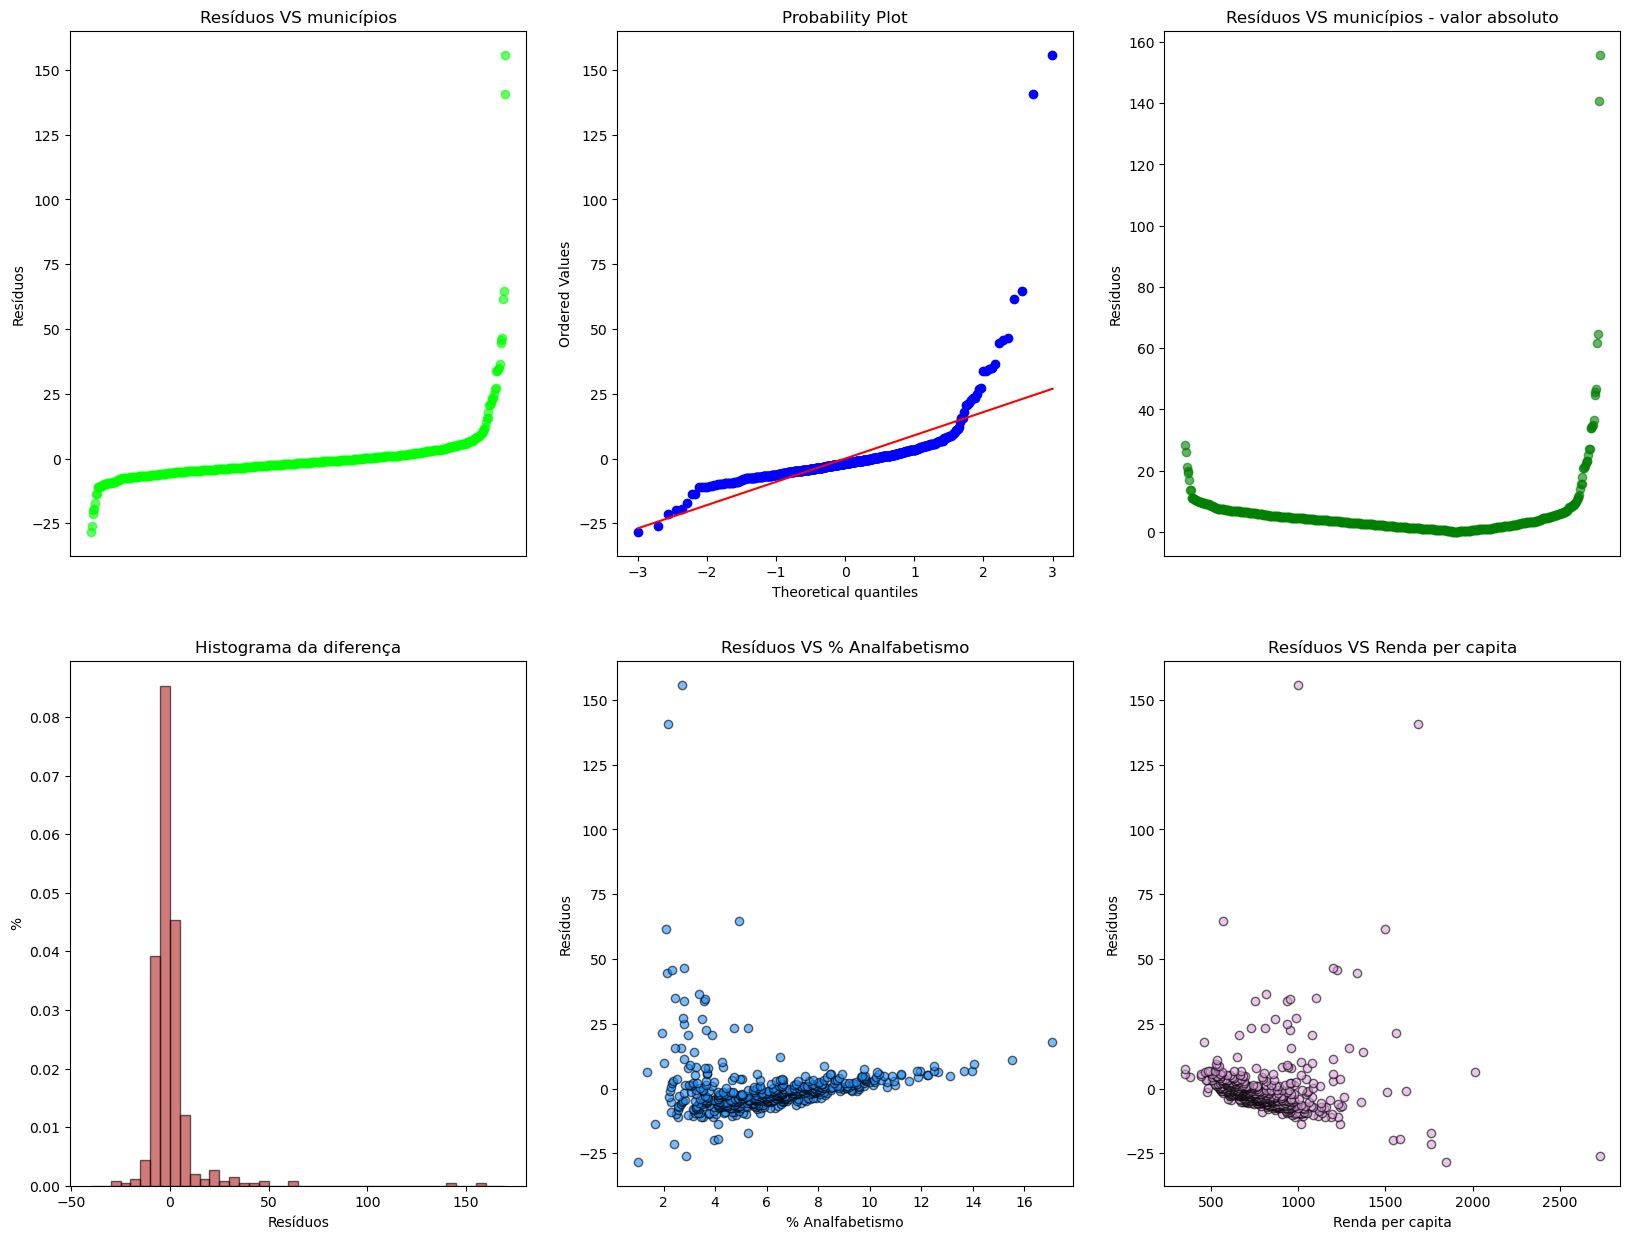

In [562]:
%matplotlib inline
plt.figure(figsize=(20,15))

#diferença entre os dois modelos
plt.subplot(2,3,1)
plt.scatter(df_modelo1.id_municipio, df_modelo1.diferença, color='lime', alpha=0.6)
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Resíduos')
plt.title('Resíduos VS municípios')

#probplot dos resíduis
plt.subplot(2,3,2)
stats.probplot(df_modelo1.diferença, dist='norm', plot=plt)

#diferença vc municípios em absoluto
plt.subplot(2,3,3)
plt.scatter(df_modelo1.id_municipio, abs(df_modelo1.diferença), color='g', alpha=0.6)
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Resíduos')
plt.title('Resíduos VS municípios - valor absoluto')

#Histograma da diferença
plt.subplot(2,3,4)
bins = np.arange(-40, 175, 5)
plt.hist(df_modelo1.diferença, bins=bins, density=True, color='firebrick', edgecolor='black', alpha=0.6)
plt.ylabel('%')
plt.xlabel('Resíduos')
plt.title('Histograma da diferença')

#Diferença vs analfabetismo
plt.subplot(2,3,5)
plt.scatter(df_modelo1.proporcao_analfabetismo_15_mais, df_modelo1.diferença, color='dodgerblue', alpha=0.6, edgecolors='black')
plt.ylabel('Resíduos')
plt.xlabel('% Analfabetismo')
plt.title('Resíduos VS % Analfabetismo')

#Diferença vs renda per capita
plt.subplot(2,3,6)
plt.scatter(df_modelo1.renda_per_capita, df_modelo1.diferença, color='plum', alpha=0.6, edgecolors='black')
plt.ylabel('Resíduos')
plt.xlabel('Renda per capita')
plt.title('Resíduos VS Renda per capita')

plt.show()

 ### Fazendo um mapa de calor para melhor visualizar as correlações

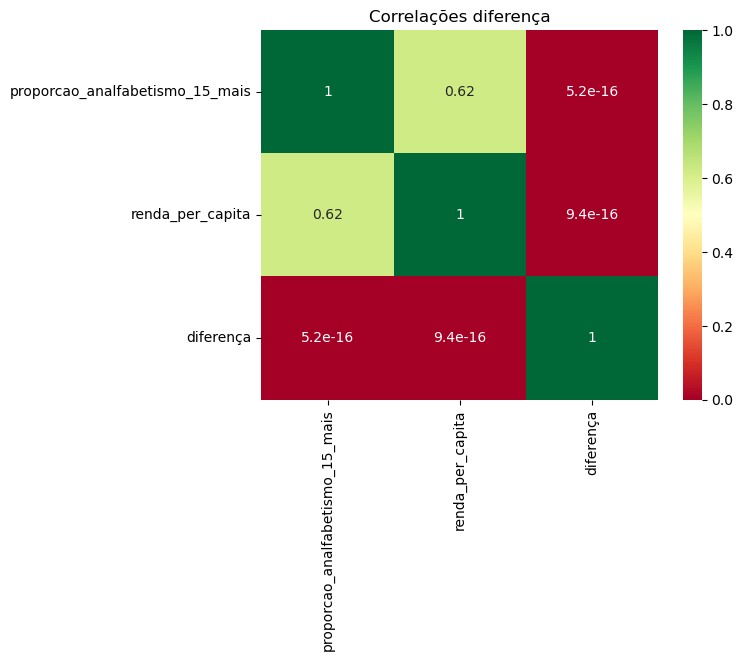

In [492]:
heatmap = df_modelo1.loc[:, ('proporcao_analfabetismo_15_mais', 'renda_per_capita', 'diferença')]
sns.heatmap(abs(heatmap.corr()), annot = True, cmap= "RdYlGn") #nota : apenas para valores absolutos
plt.title('Correlações diferença')
plt.show()

### Nota-se que a correlação entre os resíduos e as features são baixas, fato que é bom, pois, demonstro que existe pouco correlação entre os erros

 ### Agora, iremos plotar um gráfico 3D da diferença entre modelos (z) com suas features no x e y. Entretanto, para visualizá-lo deve-se abrir o arquivo no jupyter

In [493]:
beta0_hat = modelo_regress.params[0]  
beta1_hat = modelo_regress.params[1]  
beta2_hat = modelo_regress.params[2]  

def f(feature1, feature2):
    return beta0_hat + beta1_hat*feature1 + beta2_hat*feature2

In [494]:
%matplotlib notebook

npoints = 100
feature1 = df_modelo1['renda_per_capita']
feature2 = df_modelo1['proporcao_analfabetismo_15_mais']
x_vc = np.linspace(feature1.min(), feature1.max(), npoints)
y_vc = np.linspace(feature2.min(), feature2.max(), npoints)

eixo_x, eixo_y = np.meshgrid(x_vc, y_vc)

fit_z = f(eixo_x, eixo_y)

plt3d = plt.subplot(projection='3d')
plt3d.plot_surface(eixo_x, eixo_y, fit_z)
plt3d.scatter(feature1, feature2, Y, color="r")
plt3d.set_xlabel("Renda per capita")
plt3d.set_ylabel("Proporção Analfabetismo")
plt3d.set_zlabel("Previsão")
plt.show()

<IPython.core.display.Javascript object>

 ### Validando a regressão linear

In [555]:
kfold  = KFold(n_splits=10, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.
lasso = linear_model.Lasso()
x = df_modelo1[['renda_per_capita','proporcao_analfabetismo_15_mais']]
y = df_modelo1['Homicidio_total'] #utilizando o df treino
result = cross_val_score(lasso, x, y, cv = kfold)

print("K-Fold (R^2) Scores: {0}".format(result))
print("Mean R^2 for Cross-Validation K-Fold: {0}".format(result.mean()))

K-Fold (R^2) Scores: [ 0.23000413  0.2934095   0.06028807 -0.35199296  0.11649269 -0.12346885
  0.16366462 -0.10879286  0.19973438  0.36340253]
Mean R^2 for Cross-Validation K-Fold: 0.08427412592636914


 ### Observando como o modelo se comporta em uma base nova

In [569]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_treino_imputed = imputer.fit_transform(X_treino_r)

In [571]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino_imputed)

In [572]:
lasso.fit(X_treino_r, y_treino_r)
y_pred = lasso.predict(X_teste_r)
mse = mean_squared_error(y_teste_r, y_pred)
# Imprimir o MSE
print("Erro Médio Quadrático (MSE) na base de testes:", mse)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Com a nossa regressão linear completa, agora devemos utilizar uma segunda técnica de predição para criar um outro modelo. Esta será feito através da biblioteca Random Forest

### Primeiro deve-se criar mais uma divisão entre treino e teste

In [496]:
X_train, X_test, y_train, y_test = train_test_split(tabela_sem_sp[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais','proporcao_sem_renda_18_mais','indice_gini']], tabela_sem_sp['Homicidio_total'], test_size=0.3, random_state=0)

### Escolhendo 1000 árvores para o modelo

In [497]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42)
regressor.fit(X_train, y_train) #utilizando a base de treino para criar um modelo

RandomForestRegressor(n_estimators=1000, random_state=42)

### Previsão, comparando y previsto com o real

In [498]:
y_pred = regressor.predict(X_test)
df=pd.DataFrame({'Homicídios reais':y_test, 'Previsão':y_pred}) 
df

,Homicídios reais,Previsão
459,0.0,2.846
425,0.0,1.109
448,0.0,2.484
542,39.0,27.109
559,19.0,11.237
...,...,...
480,0.0,0.597
471,4.0,4.158
563,1.0,75.445
13,0.0,0.816


### Validação

In [499]:
print('Média absoluta dos erros:', metrics.mean_absolute_error(y_test, y_pred))
print('Média absoluta ao quadrado dos erros:', metrics.mean_squared_error(y_test, y_pred))
print('Raíz da média absoluta ao quadrado dos erros:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Média absoluta dos erros: 5.297177083333334
Média absoluta ao quadrado dos erros: 149.36605364583332
Raíz da média absoluta ao quadrado dos erros: 12.221540559431668


### Comparação de df teste e modelo

In [502]:
plt.figure(figsize=(8, 5))


ax = sns.distplot(y_test, hist=False, color="r", label="Factual")
sns.distplot(y_pred, hist=False, color="b", label="Previsão" , ax=ax)


plt.title('Factual VS previsão')

plt.legend()
plt.show()
plt.close()

<IPython.core.display.Javascript object>

### Visualizando como uma árvore pode se ramificar e convergir em um ponto

In [503]:
Tree = regressor.estimators_[5] #escolhendo uma árvore
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14)

plt.show()

<IPython.core.display.Javascript object>